# Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection 
This is the code for the paper entitled "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)" accepted in Workshop on Autonomous Cybersecurity (AutonomousCyber 2024), ACM CCS 2024 (Top Cybersecurity Conference).  
Authors: Li Yang (liyanghart@gmail.com) and Abdallah Shami  

If you find this repository useful in your research, please cite:  
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb
import time

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [28]:
# Read the dataset
df = pd.read_csv('Data/CICIDS2017_sample_0.02.csv')

In [29]:
# print the class distribution of the last column
df['Label'].value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Data pre-processing

In [30]:
# Encode the dataset
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])


In [31]:
# address empty values
if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace = True) 

In [32]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Machine learning model training

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

#### DT

Training time:  1.4612987041473389
Prediction time per sample:  0.00044006351695460025
Cross-Validation scores:  [0.99490404 0.99291813 0.9935138 ]
Mean of Cross-Validation scores:  0.9937786550171627
Accuracy of DT: 0.9955881055325156
Precision of DT: 0.9955619442695871
Recall of DT: 0.9955881055325156
F1-score of DT: 0.9955567987296642
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.80      0.57      0.67         7
           5       1.00      1.00      1.00      1589
           6       0.99      1.00      0.99       436

    accuracy                           1.00     11333
   macro avg       0.96      0.93      0.95     11333
weighted avg       1.00      1.00      1.00     11333



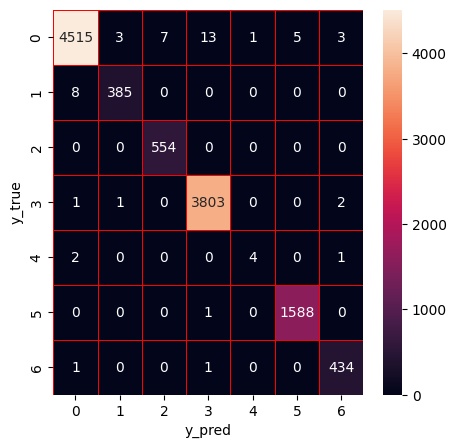

CPU times: total: 4.33 s
Wall time: 5 s


In [33]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### RF

Training time:  16.45930314064026
Prediction time:  0.033181731660715495 ms
Cross-Validation scores:  [0.99364659 0.99371236 0.99404329]
Mean of Cross-Validation scores:  0.9938007446645121
Accuracy of RF: 0.9951469160857672
Precision of RF: 0.9951376956404765
Recall of RF: 0.9951469160857672
F1-score of RF: 0.9951233485431371
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.98      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



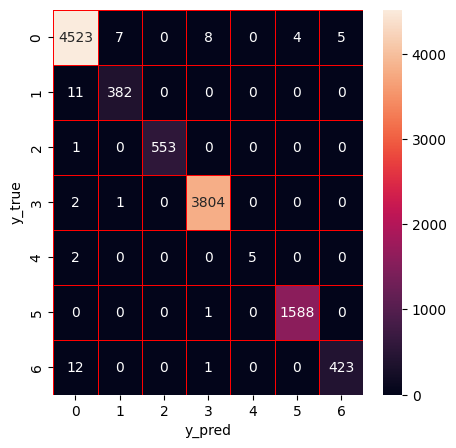

CPU times: total: 36.6 s
Wall time: 44.8 s


In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### ET

Training time:  9.446037530899048
Prediction time:  0.029573097218905883 ms
Cross-Validation scores:  [0.98808736 0.98768946 0.98828513]
Mean of Cross-Validation scores:  0.9880206480164281
Accuracy of ET: 0.9894996911673872
Precision of ET: 0.9895868550132068
Recall of ET: 0.9894996911673872
F1-score of ET: 0.9894399241016295
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4547
           1       0.93      0.97      0.95       393
           2       0.98      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.43      0.60         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.96      0.97       436

    accuracy                           0.99     11333
   macro avg       0.98      0.91      0.93     11333
weighted avg       0.99      0.99      0.99     11333



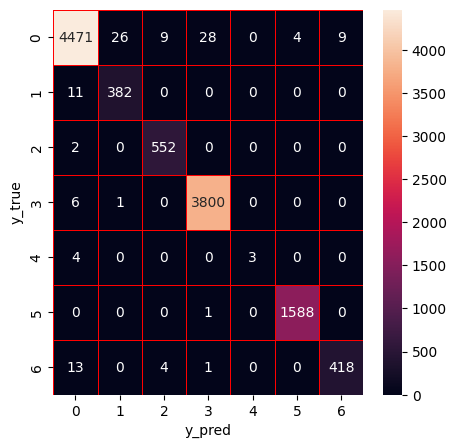

CPU times: total: 23.6 s
Wall time: 28.8 s


In [35]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0)
et_scores = cross_val_score(et, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
et.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(X_test) * 1000, 'ms')


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  35.850178480148315
Prediction time per sample:  0.002904339269201995
Cross-Validation scores:  [0.9971542  0.99728639 0.99695546]
Mean of Cross-Validation scores:  0.9971320150417519
Accuracy of XGBoost: 0.9981470043236566
Precision of XGBoost: 0.9981468800890866
Recall of XGBoost: 0.9981470043236566
F1-score of XGBoost: 0.9981299358057846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       1.00      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



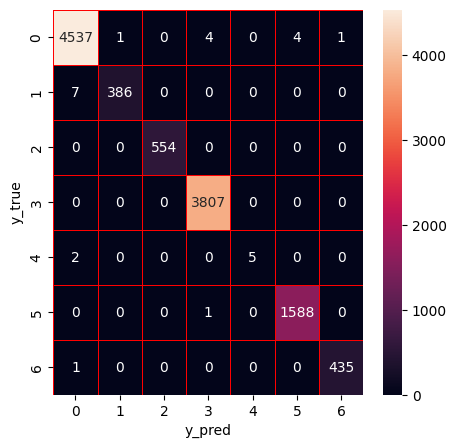

In [36]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0)
xg_scores = cross_val_score(xg, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
xg.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### LightGBM

Training time:  6.52846097946167
Prediction time per sample:  0.008625459515342621
Cross-Validation scores:  [0.99722038 0.50095969 0.99662453]
Mean of Cross-Validation scores:  0.8316015350589306
Accuracy of LightGBM: 0.7114621018265244
Precision of LightGBM: 0.730995389977396
Recall of LightGBM: 0.7114621018265244
F1-score of LightGBM: 0.7091902373464247
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      4547
           1       0.30      0.67      0.42       393
           2       0.00      0.00      0.00       554
           3       0.69      0.83      0.76      3807
           4       0.00      0.00      0.00         7
           5       0.82      0.92      0.87      1589
           6       0.45      0.22      0.29       436

    accuracy                           0.71     11333
   macro avg       0.45      0.47      0.44     11333
weighted avg       0.73      0.71      0.71     11333



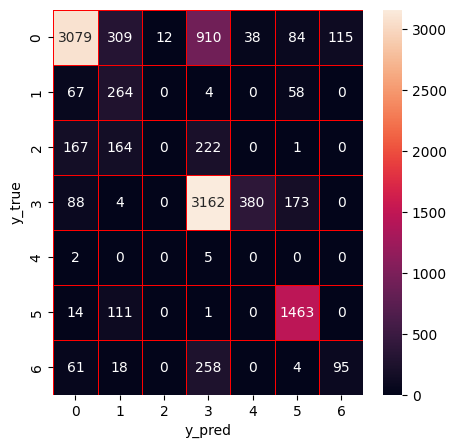

In [37]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0)
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
lgbm.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)



y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### Catboost

Training time:  84.00885319709778
Prediction time per sample:  0.0303641512567932
Cross-Validation scores:  [0.99662475 0.99688927 0.99695546]
Mean of Cross-Validation scores:  0.9968231600425393
Accuracy of CatBoost: 0.9972646254301597
Precision of CatBoost: 0.9972667325353783
Recall of CatBoost: 0.9972646254301597
F1-score of CatBoost: 0.9972288336160174
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.57      0.73         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.94      0.96     11333
weighted avg       1.00      1.00      1.00     11333



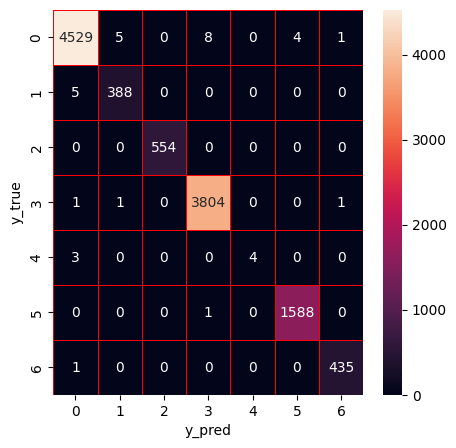

In [38]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False)
cat_scores = cross_val_score(cat, X_train, y_train, cv=3)


# calculate the training time
start = time.time()
cat.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [39]:
# record the results
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)
dt_prob_train=dt.predict_proba(X_train)
dt_prob_test=dt.predict_proba(X_test)

rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)
rf_prob_train=rf.predict_proba(X_train)
rf_prob_test=rf.predict_proba(X_test)

et_train=et.predict(X_train)
et_test=et.predict(X_test)
et_prob_train=et.predict_proba(X_train)
et_prob_test=et.predict_proba(X_test)

xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)
xg_prob_train=xg.predict_proba(X_train)
xg_prob_test=xg.predict_proba(X_test)

lgbm_train=lgbm.predict(X_train)
lgbm_test=lgbm.predict(X_test)
lgbm_prob_train=lgbm.predict_proba(X_train)
lgbm_prob_test=lgbm.predict_proba(X_test)

cat_train=cat.predict(X_train)
cat_test=cat.predict(X_test)
cat_prob_train=cat.predict_proba(X_train)
cat_prob_test=cat.predict_proba(X_test)


## Model selection

In [40]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [41]:
top_3_models

['xg', 'cat', 'rf']

## Model Ensemble

In [42]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

Training time of Stacking: 3.4441423416137695
Testing time of Stacking: 0.0005281267104708043
Accuracy of Stacking: 0.9981470043236566
Precision of Stacking: 0.9981468800890866
Recall of Stacking: 0.9981470043236566
F1-score of Stacking: 0.9981299358057846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       1.00      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



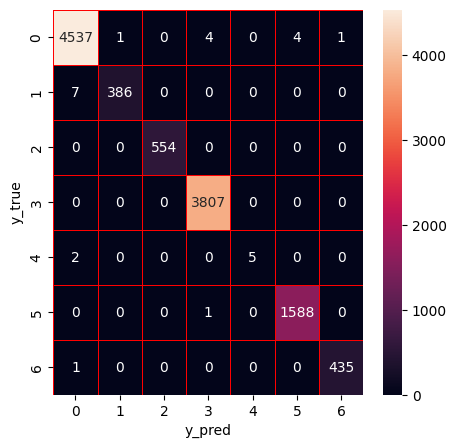

In [43]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_test = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_test)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_test)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time of Stacking: 8.537046194076538
Testing time of Stacking: 0.0006160636786737983
Accuracy of Stacking: 0.9981470043236566
Precision of Stacking: 0.9981468800890866
Recall of Stacking: 0.9981470043236566
F1-score of Stacking: 0.9981299358057846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       1.00      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



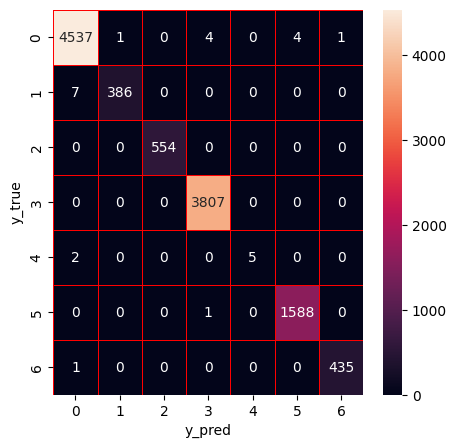

In [44]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_test)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_test)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time of Stacking: 9.290115118026733
Testing time of Stacking: 0.00492893018043442
Accuracy of Stacking: 0.9981470043236566
Precision of Stacking: 0.9981468800890866
Recall of Stacking: 0.9981470043236566
F1-score of Stacking: 0.9981299358057846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       1.00      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



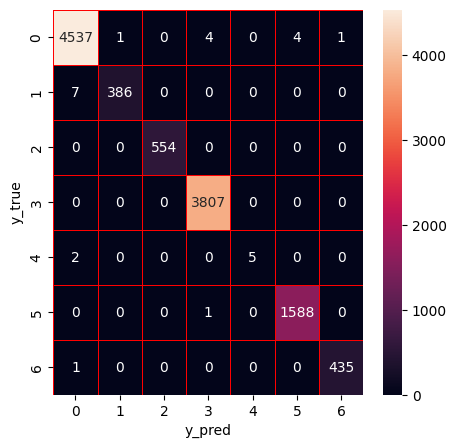

In [45]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_test)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_test)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Automated Feature Selection

In [46]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [47]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [48]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.1227, 'Bwd Packet Length Min'), (0.0767, 'Bwd Packet Length Std'), (0.0567, 'Init_Win_bytes_forward'), (0.0529, 'Average Packet Size'), (0.0507, 'Init_Win_bytes_backward'), (0.0425, 'PSH Flag Count'), (0.0359, 'Bwd Packets/s'), (0.0293, 'Avg Bwd Segment Size'), (0.0283, 'Fwd Header Length'), (0.0281, 'Bwd Header Length'), (0.0257, 'Packet Length Mean'), (0.0227, 'Packet Length Std'), (0.0212, 'Fwd PSH Flags'), (0.0206, 'Packet Length Variance'), (0.0186, 'Bwd Packet Length Mean'), (0.0174, 'Fwd Header Length.1'), (0.0165, 'min_seg_size_forward'), (0.0149, 'Flow Bytes/s'), (0.0148, 'Flow IAT Min'), (0.0147, 'Total Length of Fwd Packets'), (0.0147, 'Max Packet Length'), (0.0146, 'Bwd Packet Length Max'), (0.0139, 'Total Length of Bwd Packets'), (0.0135, 'Fwd Packet Length Mean'), (0.0127, 'Avg Fwd Segment Size'), (0.0118, 'Fwd Packet Length Max'), (0.0117, 'Fwd IAT Min'), (0.0102, 'Total Fwd Packets'), (0.0101, 'Subflow Bwd Bytes'), (0.01, 'Subflow Fwd

In [49]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [50]:
# regenerate the training and test sets with the selected features

X_fs = df[fs].values
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [51]:
X_train.shape

(45328, 39)

In [52]:
# save the dataset with the selected features
df_fs = pd.DataFrame(X_fs, columns=fs)
df_fs['Label'] = y
df_fs.to_csv('Data/CICIDS2017_sample_0.02_fs.csv', index=False)

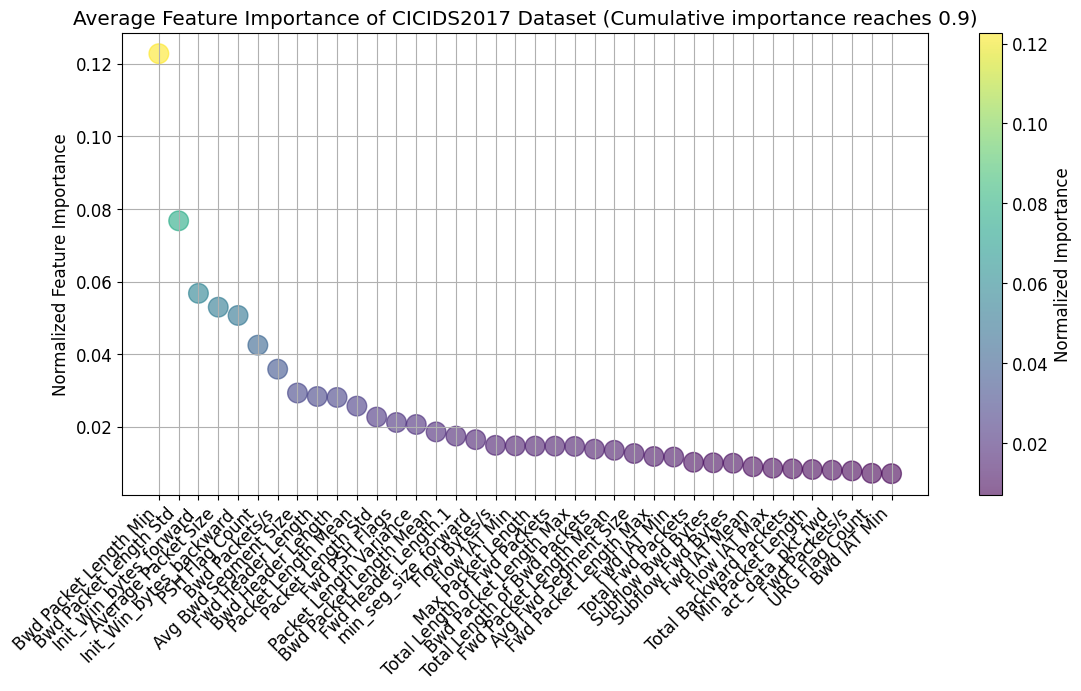

In [53]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': df.drop(['Label'],axis=1).columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

### Data Balancing by Proposed TVAE-based Method

In [54]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

In [55]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_csv(filepath='Data/CICIDS2017_sample_0.02_fs.csv')


In [56]:
training_set, test_set = train_test_split(df, test_size = 0.2, random_state = 0,stratify = df['Label'])
X_train = training_set[fs]
y_train = training_set.iloc[:, -1]
X_test = test_set[fs]
y_test = test_set.iloc[:, -1]

In [57]:
training_set['Label'].value_counts()

Label
0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

In [58]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [59]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))
    
    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata)
    
    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
    
    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)
    
    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)


In [61]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    18184
3    15228
2     6475
6     6475
1     6475
4     6475
5     6357
Name: count, dtype: int64


## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

### DT

Training time:  0.8667712211608887
Prediction time per sample:  0.00026404231768320047
Cross-Validation scores:  [0.94613979 0.99547739 0.99470053]
Mean of Cross-Validation scores:  0.9787725704360364
Accuracy of DT: 0.9947939645283684
Precision of DT: 0.9948133440436601
Recall of DT: 0.9947939645283684
F1-score of DT: 0.9947939491571862
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.98      0.98       393
           2       0.98      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.86      0.86      0.86         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.97      0.97     11333
weighted avg       0.99      0.99      0.99     11333



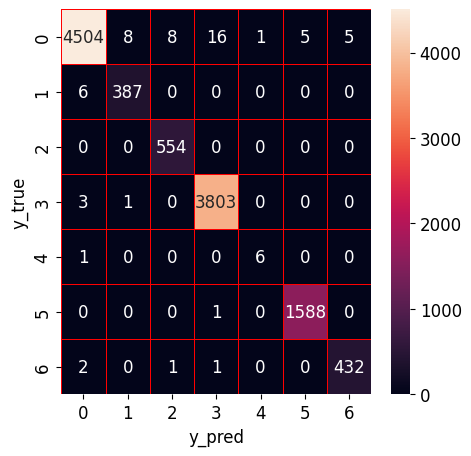

CPU times: total: 2.8 s
Wall time: 2.8 s


In [62]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [00:30<00:00,  1.54s/trial, best loss: -0.9742956319828528]
Decision Tree: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 26, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy of DT: 0.9948822024177182
Precision of DT: 0.9948915046168738
Recall of DT: 0.9948822024177182
F1-score of DT: 0.9948812479196358
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.98      0.98       393
           2       0.98      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.86      0.86      0.86         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.97      0.97     11333
weighted avg       0.99      0.99      0.99     11333



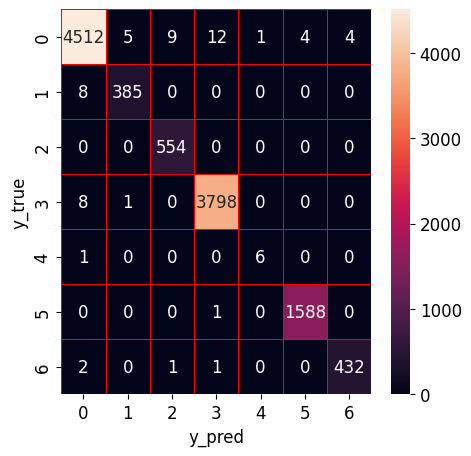

In [63]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_test)
y_true = y_test

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### RF

Training time:  11.820600748062134
Prediction time:  0.010911252674711021 ms
Cross-Validation scores:  [0.93225217 0.99803563 0.99771575]
Mean of Cross-Validation scores:  0.9760011834284702
Accuracy of RF: 0.9965587223153622
Precision of RF: 0.9965554790789681
Recall of RF: 0.9965587223153622
F1-score of RF: 0.9965392815440419
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



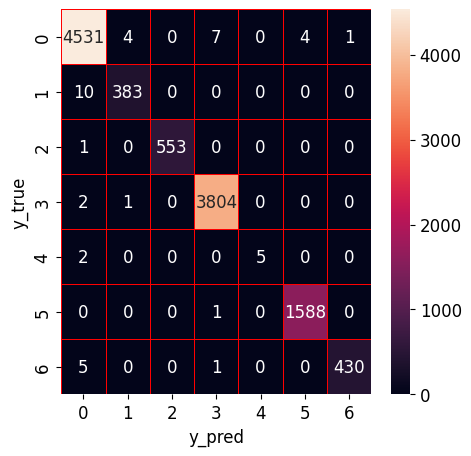

CPU times: total: 35.2 s
Wall time: 35.2 s


In [64]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0)
rf_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [23:44<00:00, 71.24s/trial, best loss: -0.9771584830012561] 
Random Forest: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 48, 'max_features': 27, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 106}
Accuracy of RF: 0.9963822465366629
Precision of RF: 0.9963830505233648
Recall of RF: 0.9963822465366629
F1-score of RF: 0.9963812892121173
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.99      0.99       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      1.00       436

    accuracy                           1.00     11333
   macro avg       0.96      0.95      0.95     11333
weighted avg       1.00      1.00      1.00     11333



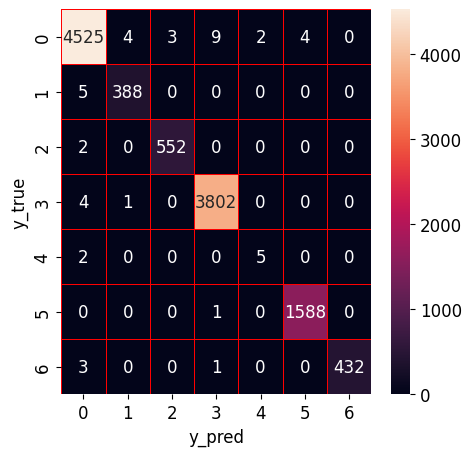

In [65]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_test)
y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### ET

Training time:  3.0809121131896973
Prediction time:  0.01232306176541311 ms
Cross-Validation scores:  [0.9241206  0.99639105 0.99657362]
Mean of Cross-Validation scores:  0.9723617568695211
Accuracy of ET: 0.9928527309626753
Precision of ET: 0.9928793046554231
Recall of ET: 0.9928527309626753
F1-score of ET: 0.9928558149251036
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.95      0.97      0.96       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.95      0.95      0.95     11333
weighted avg       0.99      0.99      0.99     11333



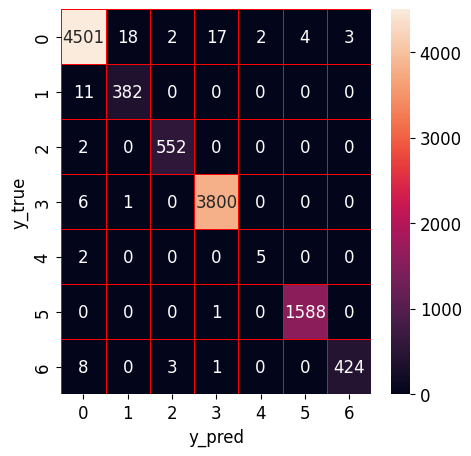

CPU times: total: 10 s
Wall time: 10 s


In [66]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0)
et_scores = cross_val_score(et, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(X_test) * 1000, 'ms')


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [02:34<00:00,  7.75s/trial, best loss: -0.9750875235276776]
Extra Trees: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 44, 'max_features': 17, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 165}
Accuracy of ET: 0.9958528192005647
Precision of ET: 0.9958556363121698
Recall of ET: 0.9958528192005647
F1-score of ET: 0.9958374839444892
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.97      0.97      0.97       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



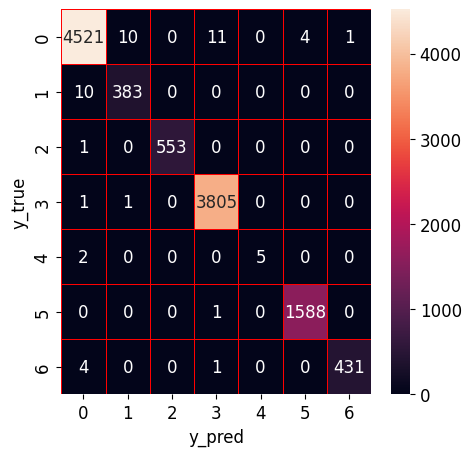

In [67]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = et.predict(X_test)
y_true = y_test

# Evaluation metrics
et_score = et.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### XGBoost

Training time:  14.824193000793457
Prediction time per sample:  0.0015841066432337912
Cross-Validation scores:  [0.93777981 0.99858383 0.99844671]
Mean of Cross-Validation scores:  0.97827011491866
Accuracy of XGBoost: 0.9978822906556075
Precision of XGBoost: 0.9978810452476734
Recall of XGBoost: 0.9978822906556075
F1-score of XGBoost: 0.9978661481364945
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



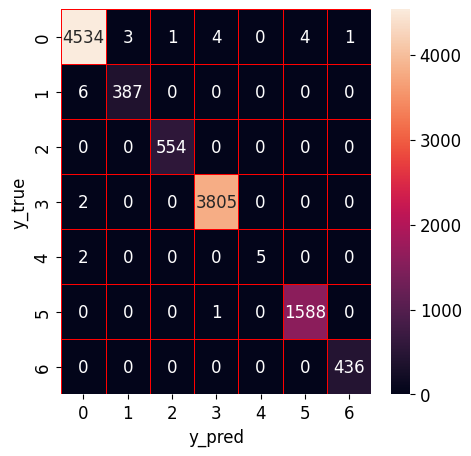

In [68]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0)
xg_scores = cross_val_score(xg, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [03:22<00:00, 10.14s/trial, best loss: -0.9977940527662579]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.4879676682780232, 'max_depth': 32, 'n_estimators': 65}
Accuracy of XGBoost: 0.9977940527662579
Precision of XGBoost: 0.9977929515415213
Recall of XGBoost: 0.9977940527662579
F1-score of XGBoost: 0.9977779063989407
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



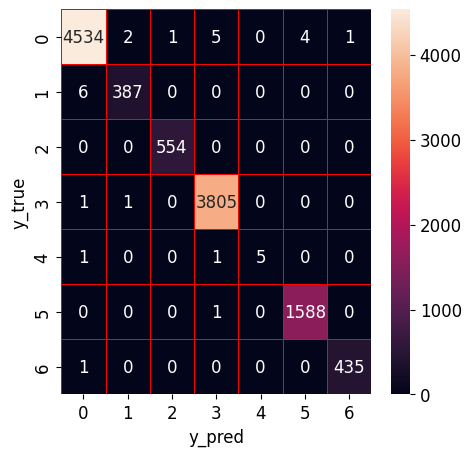

In [69]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_test)
y_true = y_test

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### LightGBM

Training time:  1.820234775543213
Prediction time per sample:  0.004224340482095981
Cross-Validation scores:  [0.93805391 0.99830973 0.99867513]
Mean of Cross-Validation scores:  0.9783462566641332
Accuracy of LightGBM: 0.9977058148769081
Precision of LightGBM: 0.9977046875647071
Recall of LightGBM: 0.9977058148769081
F1-score of LightGBM: 0.997688878348638
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



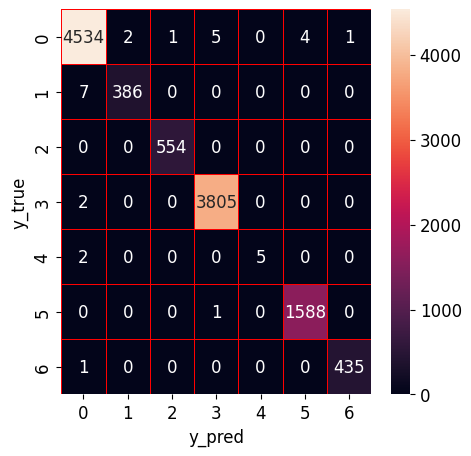

In [70]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0)
lgbm_scores = cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)



y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [00:24<00:00,  1.25s/trial, best loss: -0.9976175769875585]
LightGBM: Hyperopt estimated optimum {'learning_rate': 0.5548389313548716, 'max_depth': 100, 'min_child_samples': 60, 'n_estimators': 15, 'num_leaves': 45}
Accuracy of LightGBM: 0.9976175769875585
Precision of LightGBM: 0.9976153756950639
Recall of LightGBM: 0.9976175769875585
F1-score of LightGBM: 0.9976000971566817
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



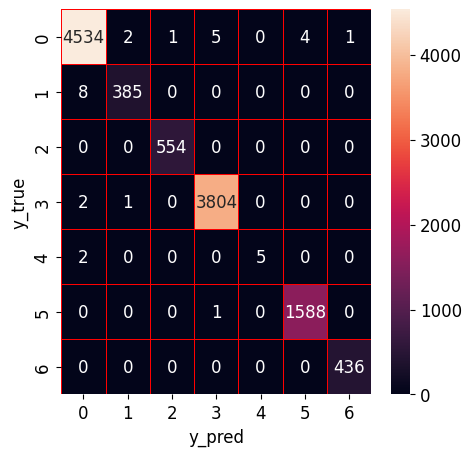

In [71]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 5),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_test)
y_true = y_test

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### CatBoost

Training time:  30.027976274490356
Prediction time per sample:  0.0011441062389357958
Cross-Validation scores:  [0.93714025 0.99826405 0.99794417]
Mean of Cross-Validation scores:  0.9777828223568278
Accuracy of CatBoost: 0.9971763875408101
Precision of CatBoost: 0.997176647229068
Recall of CatBoost: 0.9971763875408101
F1-score of CatBoost: 0.9971395429633921
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.57      0.73         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.94      0.96     11333
weighted avg       1.00      1.00      1.00     11333



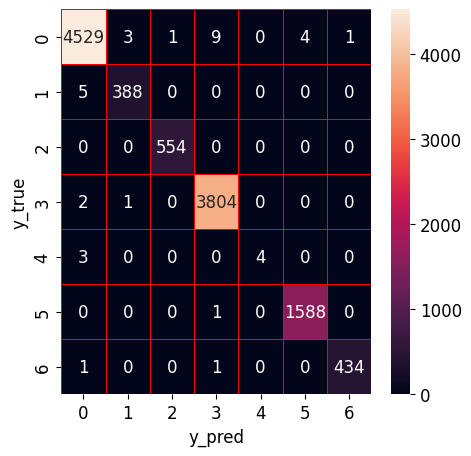

In [72]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False)
cat_scores = cross_val_score(cat, X_train_balanced, y_train_balanced, cv=3)


# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2/2 [00:33<00:00, 16.78s/trial, best loss: -0.9973528633195095]
CatBoost: Hyperopt estimated optimum {'depth': 5, 'iterations': 1000, 'learning_rate': 0.14113171790500412}
Accuracy of CatBoost: 0.9973528633195095
Precision of CatBoost: 0.997352745186135
Recall of CatBoost: 0.9973528633195095
F1-score of CatBoost: 0.9973375383121329
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



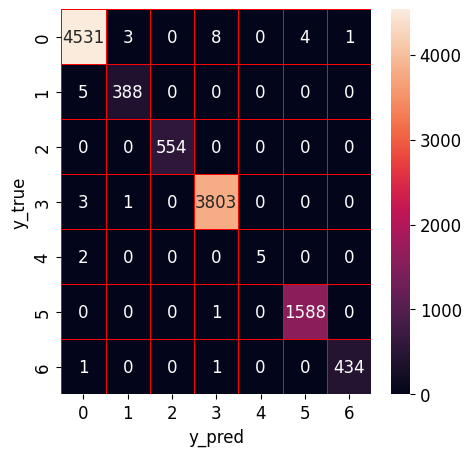

In [73]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=2)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_test)
y_true = y_test

# Evaluation metrics
cat_score = cat.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [74]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_test=dt.predict(X_test)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_test=dt.predict_proba(X_test)

rf_train=rf.predict(X_train_balanced)
rf_test=rf.predict(X_test)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_test=rf.predict_proba(X_test)

et_train=et.predict(X_train_balanced)
et_test=et.predict(X_test)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_test=et.predict_proba(X_test)

xg_train=xg.predict(X_train_balanced)
xg_test=xg.predict(X_test)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_test=xg.predict_proba(X_test)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_test=lgbm.predict(X_test)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_test=lgbm.predict_proba(X_test)

cat_train=cat.predict(X_train_balanced)
cat_test=cat.predict(X_test)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_test=cat.predict_proba(X_test)


## Model selection

In [75]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [76]:
top_3_models

['dt', 'lgbm', 'xg']

In [77]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

Accuracy of Stacking: 0.9978822906556075
Precision of Stacking: 0.997881313485891
Recall of Stacking: 0.9978822906556075
F1-score of Stacking: 0.9978661122587069
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



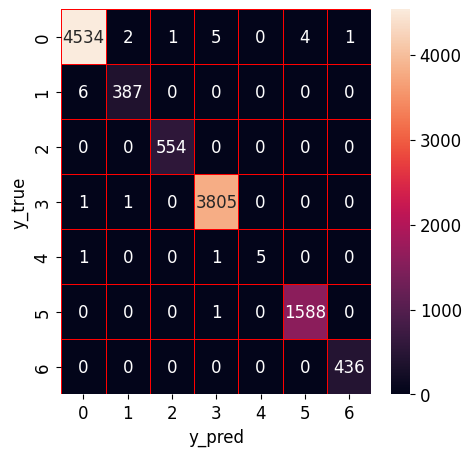

In [78]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
X_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_test = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(X_train_balanced, y_train_balanced)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Accuracy of Stacking: 0.9973528633195095
Precision of Stacking: 0.9973531762405455
Recall of Stacking: 0.9973528633195095
F1-score of Stacking: 0.9973516745314188
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.86      0.86      0.86         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       0.98      0.98      0.98     11333
weighted avg       1.00      1.00      1.00     11333



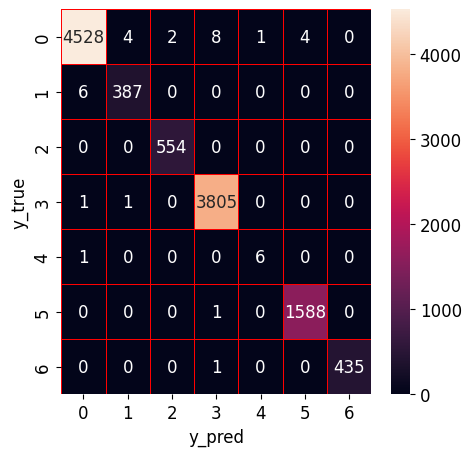

In [79]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
X_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(X_train_balanced, y_train_balanced)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy of Stacking: 0.9977940527662579
Precision of Stacking: 0.9977928768369768
Recall of Stacking: 0.9977940527662579
F1-score of Stacking: 0.9977779450001537
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



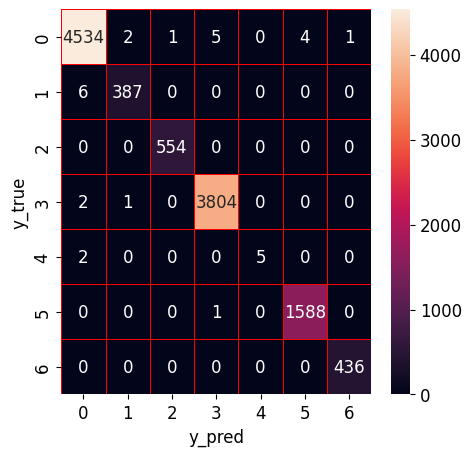

In [80]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
X_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(X_train_balanced, y_train_balanced)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# PS: the hyperparameter optimization process is the same as the previous steps